MaxPool2D bir yoğunlaştırma katmanıdır.<br><br>
* MaxiPool2D katmanı, çekirdek yerine basit bir maksimum fonksiyonu kullanması dışında Conv2D katmanına çok benzer.<br>
* *pool_size* parametresi *kernel_size* parametresine benzer.<br>
* MaxPool2D çekirdeğinde bir evrişim katmanının yaptığı gibi eğitilebilir ağırlıklara sahip değildir.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

# önceki yaptığımız modele condense(yoğunlaştırma) adımı ekliyoruz
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up ouyput cells

# Read images
image_path = "datas/car2.jpeg"
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

# Define kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
], dtype=tf.float32)

# Reformat for batch compatibility
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [1, 1, 3, 3])

# Filter step
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME'
)

# Detect step
image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131) # satır kolon index
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')

plt.subplot(132) # satır kolon index
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')

plt.subplot(133) # satır kolon index
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfd in position 89: invalid start byte

Havuzlama adımı için tf.nn.pool fonksiyonu kullanacağız. Bu, model oluştururken kullandığımız MaxPool2D katmanıyla aynı şeyi yapar. Basit bir fonksiyon olduğu için doğrudan kullanımı daha kolaydır.

In [5]:
import tensorflow as tf

image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # The Sliding Window dersinde bahsedilecek
    strides=(2, 2),
    padding='SAME'
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show()

NameError: name 'image_detect' is not defined

# Translation Invariance (Çeviri Değişmezliği)

0 pozisyonları tamamen önemsiz değildir, pozisyon bilgisi taşır. Boş alan, özelliği görüntü içinde konumlandırmaya devam eder. MaxPool2D, bu piksellerin bazılarını kaldırdığında özellik haritasındaki pozisyon bilgilerinin bir kısmını kaldırır. Bu, bir convnet'e translation invariance (çeviri değişmezliği) adı verir. Bu, maksimum havuzlamaya sahip bir konvnet'in özellikleri görüntüdeki konumlarına göre ayırt etme eğiliminde olmayacağı anlamına gelir.<br><br>

Not: Translation(çeviri), bir şeyi, döndürmeden veya şeklini veya boyutunu değiştirmeden konumunu değiştirmek için kullanılan matematiksel bir kelimedir.

In [8]:
import numpy as np
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex3 import *
from matplotlib import gridspec
import learntools.computer_vision.visiontools as visiontools
import tensorflow as tf

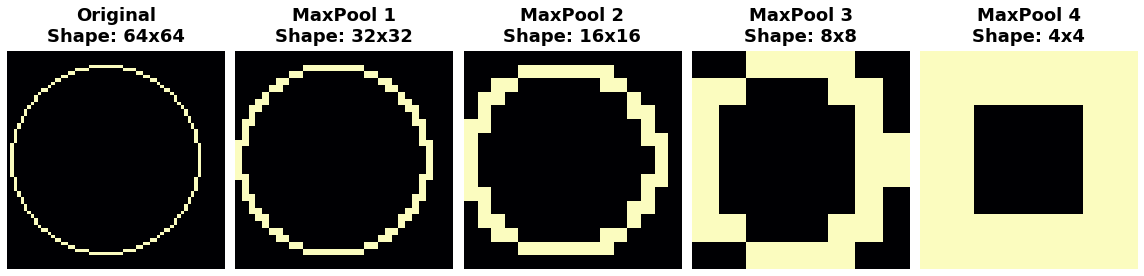

In [17]:
REPEATS = 4
SIZE = [64, 64]

# Create a randomly shifted circle
image = visiontools.circle(SIZE, r_shrink=4, val=1)
image = tf.expand_dims(image, axis=-1)
image = visiontools.random_transform(image, jitter=3, fill_method='replicate')
image = tf.squeeze(image)

plt.figure(figsize=(16, 4))
plt.subplot(1, REPEATS+1, 1)
plt.imshow(image, vmin=0, vmax=1)
plt.title("Original\nShape: {}x{}".format(image.shape[0], image.shape[1]))
plt.axis('off')

# image
for i in range(REPEATS):
    ax = plt.subplot(1, REPEATS+1, i+2)
    image = tf.reshape(image, [1, *image.shape, 1])
    image = tf.nn.pool(image, window_shape=(2,2), strides=(2, 2), padding='SAME', pooling_type='MAX')
    image = tf.squeeze(image)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title("MaxPool {}\nShape: {}x{}".format(i+1, image.shape[0], image.shape[1]))
    plt.axis('off')

# Global Average Pooling

GlobalAvgPool2D katmanı, genellikle ağın başındaki gizli yoğun katmanların bazılarına veya tümüne alternatif olarak kullanılır.<br><br>

Özelliği yığından çıkarmak yerine (Flatten(düzleştirme) gibi), tüm özellik haritasını ortalama değeriyle değiştirir.<br>
Çok yıkıcı olmasına rağmen, genellikle çok iyi çalışır ve modeldeki parametre sayısını azaltma avantajına sahiptir.

In [ ]:
#model = keras.Sequantial([
#    pretrained_base,
#    layers.GlobalAvgPool2D(),
#    layers.Dense(1, activation='sigmoid')
#])

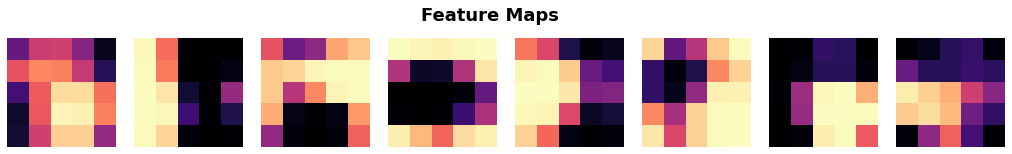

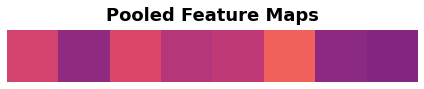

In [12]:
feature_maps = [visiontools.random_map([5, 5], scale=0.1, decay_power=4) for _ in range(8)]

gs = gridspec.GridSpec(1, 8, wspace=0.1, hspace=0.01) # subplot gibi
plt.figure(figsize=(18, 2))

for i, feature_map in enumerate(feature_maps):
    plt.subplot(gs[i])
    plt.imshow(feature_map, vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle('Feature Maps', size=18, weight='bold', y=1.1)
plt.show()


# Tensorflow için yeniden formatlama
feature_maps_tf = [tf.reshape(feature_map, [1, *feature_map.shape, 1]) for feature_map in feature_maps]

global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
pooled_maps = [global_avg_pool(feature_map) for feature_map in feature_maps_tf]
img = np.array(pooled_maps)[:, :, 0].T

plt.imshow(img, vmin=0, vmax=1)
plt.axis('off')
plt.title('Pooled Feature Maps')
plt.show()

In [40]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.applications.vgg16 import VGG16

IMAGE = [128, 128]

# VGG16 yükleme
pretrained_base = VGG16(input_shape=IMAGE + [3], weights='imagenet', include_top=False)
#pretrained_base = tf.keras.models.load_model('../input/cv-course-models/cv-course-models/vgg16-pretrained-base')

#for layer in pretrained_base.layers:
#    layer.trainable = False
# or
#pretrained_base.trainable=False

model = keras.Sequential([
    pretrained_base,
    # base'den sonra global average pooling katmanını ekle
    layers.GlobalAvgPool2D()
])

# Dataset yükleme
ds = image_dataset_from_directory(
    'datas/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=1,
    shuffle=True,
)

ds_iter = iter(ds) # verilen argüman için bir iterasyon döndürür.

Found 5117 files belonging to 2 classes.


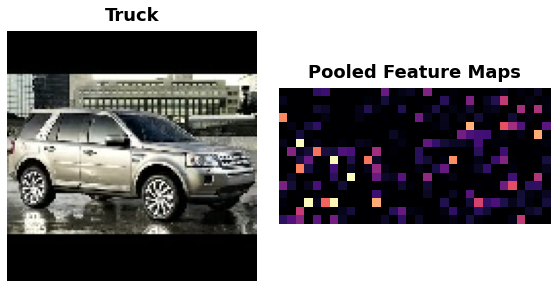

In [43]:
car = next(ds_iter)

car_tf = tf.image.resize(car[0], size=[128, 128])
car_features = model(car_tf)
car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1].numpy()))

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Car", "Truck"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Pooled Feature Maps')
plt.axis('off')
plt.show()

Özellik çıkarma sürecindeki son işlemi araştırdık: maksimum havuzlama ile yoğunlaştırma. Havuzlama, evrişimli ağların temel özelliklerinden biridir ve onlara bazı karakteristik avantajları sağlamaya yardımcı olur: görsel verilerle verimlilik, yoğun ağlara kıyasla daha düşük parametre boyutu, çeviri değişmezliği. Sadece öznitelik çıkarımı sırasında tabanda değil, sınıflandırma sırasında da head'de kullanılabileceğini gördük. Konvnetleri tam olarak anlamak için bunu anlamak önemlidir.